In [1]:
# SQL config

import pyodbc
import pandas as pd
con = pyodbc.connect('Trusted_Connection=yes', driver = '{SQL Server}',server = 'WINNYRPDB01', database = 'allocations')
cursor = con.cursor()

In [2]:
#SQL query to pull raw data

data17 =  pd.read_sql_query ("""DECLARE @date1  DATETIME,
        @date2  DATETIME

SET @date1 = '1/1/17'
SET @date2 = '12/31/17'

Select 
--cs.JobID
 cs.JobCode
,cs.deptcount
,cs.srhrs
,cs.midhrs
,cs.jrhrs
,cs.srhrs/cs.[Total Hours] as Psrhrs
,cs.midhrs/cs.[Total Hours] as Pmidhrs
,cs.jrhrs/cs.[Total Hours] as PjrHrs
,cs.officecount
,cs.ptodays
,cs.pjduration
,cs.additionalassignments
,cs.teamsize
,cs.projtags
,case when cs.BurnLTD > cs.SOW then '1' else 0 end as overbudget
--,cs.[Total Hours]
--,cs.[YTD Hrs]
--,(cs.[YTD Hrs]/nullif(cs.[Total Hours],0))*100.0 as [%hrsinyear]
--,cs.[%Complete]

from


(Select 

 p.jobID

, p.JobCode

, count(distinct(jb.DeptID))as deptcount

,(Select  isnull(SUM(convert(float,t.TimeSpan)/60.0/60.0),0) 
   from timeentry t inner join 
   UserTitleRec tr1 on tr1.userid=t.userid inner join
   jobtitles jb1 on jb1.titleid=tr1.TitleID
   where t.jobID=p.JobID and t.timeday>=tr1.titlestartdate and t.timeday<= isnull(tr1.titleEnddate,'1/1/2079') and jb1.GroupAuthLevel in (344,345,346,347)) as srhrs

,(Select  isnull(SUM(convert(float,t.TimeSpan)/60.0/60.0),0) 
   from timeentry t inner join 
   UserTitleRec tr1 on tr1.userid=t.userid inner join
   jobtitles jb1 on jb1.titleid=tr1.TitleID
   where t.jobID=p.JobID and t.timeday>=tr1.titlestartdate and t.timeday<= isnull(tr1.titleEnddate,'1/1/2079') and jb1.GroupAuthLevel =343) as midhrs

,(Select  isnull(SUM(convert(float,t.TimeSpan)/60.0/60.0),0) 
   from timeentry t inner join 
   UserTitleRec tr1 on tr1.userid=t.userid inner join
   jobtitles jb1 on jb1.titleid=tr1.TitleID
   where t.jobID=p.JobID and t.timeday>=tr1.titlestartdate and t.timeday<= isnull(tr1.titleEnddate,'1/1/2079') and jb1.GroupAuthLevel =342) as jrhrs

,count(distinct (prr.PayRegionID)) as officecount

, (select count(hr.RequestApproved) from HR_outOfOfficeRecord hr inner join
   (select distinct (t1.userid) from timeEntry t1 where t1.JobID=p.jobID) g on g.UserID=hr.UserID
   where  hr.DayOut>=p.projStartDate and hr.DayOut<= p.currentEndDate) ptodays

,datediff(day,p.projStartDate,p.currentEndDate) pjduration

,(select count (g.userid) 
from (select distinct a2.UserID,a2.JobID 
 from  timeEntry a2 inner join
 AllOpenJobs j1 on a2.JobID=j1.JobID
 where a2.timeDay<=p.currentEndDate and a2.timeDay>=p.projStartDate and a2.jobid<> p.jobID  and j1.IsNonBillable=0 and 
a2.UserID in (Select a3.userID from assignments a3 where a3.jobid = p.jobid and a3.UserID<>0) 
) g ) additionalassignments

,count(distinct (a.userid)) as teamsize

,(select count(pj.tagID) from projTags pj where pj.Jobid=p.jobID) as projtags

,(case WHEN p.FixedContractAmount > 0 then p.FixedContractAmount else 0.0 end) SOW

,ISNULL((SELECT SUM(convert(float,t.TimeSpan)*convert(float,rce.BillingRate)/60.0/60.0) FROM timeEntry as t INNER JOIN
RateCardEntries as rce on rce.RateCardTableID = p.RateCardTableID AND rce.TitleID=t.UserTitleID
WHERE t.jobid=p.jobid and t.timeDay < @date2),0.0) as BurnLTD

,ISNULL((SELECT SUM(convert(float,TimeSpan)/60.0/60.0) FROM timeEntry WHERE jobid=p.jobid),0.0) as [Total Hours]

,ISNULL((SELECT SUM(convert(float,TimeSpan)/60.0/60.0) FROM timeEntry WHERE YEAR(timeDay)=Year(@date2) and jobid=p.jobid),0.0) as [YTD Hrs] 

,(SELECT TOP (1) JobValueValue
     FROM            JobIntValues
     WHERE        (JobID = p.jobID) AND (ValueType = 1)
     ORDER BY setOn DESC) as [%Complete]

From AllOpenJobs p inner join
Assignments a on a.jobID = p.JobID inner join
userTitleRec tr on tr.userid=a.userid and tr.TitleStartDate <= p.currentEndDate and isnull(tr.TitleEndDate,'1/1/2079')> p.projStartDate inner join
JobTitles jb on jb.TitleID=tr.TitleID inner join
k_NameValues as k on k.k_NameValueID = jb.GroupAuthLevel inner join
payRateRecs AS prr ON prr.UserID = a.UserID and prr.RateStartDate <= p.currentEndDate and isnull(prr.RateEndDate,'1/1/2077')  >= p.projStartDate  


where p.retainerID = 0 AND p.projStartDate <= @date2 AND p.currentEndDate >= @date1 and p.IsNonbillable=0 and jb.DeptID <> 0 

Group by p.JobID,p.JobCode,p.projStartDate,p.currentEndDate, p.FixedContractAmount,p.RateCardTableID ) cs


 where (cs.[YTD Hrs]/nullif(cs.[Total Hours],0)) >= .50 and cs.[%Complete] > 95""",con)

In [3]:
# Export data to CSV

data17.to_csv('data17_modified.csv')

In [2]:
data16 =  pd.read_sql_query ("""DECLARE @date1  DATETIME,
        @date2  DATETIME

SET @date1 = '1/1/16'
SET @date2 = '12/31/16'

Select 
--cs.JobID
 cs.JobCode
,cs.deptcount
,cs.srhrs
,cs.midhrs
,cs.jrhrs
,cs.officecount
,cs.ptodays
,cs.pjduration
,cs.additionalassignments
,cs.teamsize
,cs.projtags
,case when cs.BurnLTD > SOW then '1' else 0 end as overbudget
--,cs.[Total Hours]
--,cs.[YTD Hrs]
--,(cs.[YTD Hrs]/nullif(cs.[Total Hours],0))*100.0 as [%hrsinyear]
--,cs.[%Complete]

from


(Select 

 p.jobID

, p.JobCode

, count(distinct(jb.DeptID))as deptcount

,(Select  isnull(SUM(convert(float,t.TimeSpan)/60.0/60.0),0) 
   from timeentry t inner join 
   UserTitleRec tr1 on tr1.userid=t.userid inner join
   jobtitles jb1 on jb1.titleid=tr1.TitleID
   where t.jobID=p.JobID and t.timeday>=tr1.titlestartdate and t.timeday<= isnull(tr1.titleEnddate,'1/1/2079') and jb1.GroupAuthLevel in (344,345,346,347)) as srhrs

,(Select  isnull(SUM(convert(float,t.TimeSpan)/60.0/60.0),0) 
   from timeentry t inner join 
   UserTitleRec tr1 on tr1.userid=t.userid inner join
   jobtitles jb1 on jb1.titleid=tr1.TitleID
   where t.jobID=p.JobID and t.timeday>=tr1.titlestartdate and t.timeday<= isnull(tr1.titleEnddate,'1/1/2079') and jb1.GroupAuthLevel =343) as midhrs

,(Select  isnull(SUM(convert(float,t.TimeSpan)/60.0/60.0),0) 
   from timeentry t inner join 
   UserTitleRec tr1 on tr1.userid=t.userid inner join
   jobtitles jb1 on jb1.titleid=tr1.TitleID
   where t.jobID=p.JobID and t.timeday>=tr1.titlestartdate and t.timeday<= isnull(tr1.titleEnddate,'1/1/2079') and jb1.GroupAuthLevel =342) as jrhrs

,count(distinct (prr.PayRegionID)) as officecount

, (select count(hr.RequestApproved) from HR_outOfOfficeRecord hr inner join
   (select distinct (t1.userid) from timeEntry t1 where t1.JobID=p.jobID) g on g.UserID=hr.UserID
   where  hr.DayOut>=p.projStartDate and hr.DayOut<= p.currentEndDate) ptodays

,datediff(day,p.projStartDate,p.currentEndDate) pjduration

,(select count (g.userid) 
from (select distinct a2.UserID,a2.JobID 
 from  timeEntry a2 inner join
 AllOpenJobs j1 on a2.JobID=j1.JobID
 where a2.timeDay<=p.currentEndDate and a2.timeDay>=p.projStartDate and a2.jobid<> p.jobID  and j1.IsNonBillable=0 and 
a2.UserID in (Select a3.userID from assignments a3 where a3.jobid = p.jobid and a3.UserID<>0) 
) g ) additionalassignments

,count(distinct (a.userid)) as teamsize

,(select count(pj.tagID) from projTags pj where pj.Jobid=p.jobID) as projtags

,(case WHEN p.FixedContractAmount > 0 then p.FixedContractAmount else 0.0 end) SOW

,ISNULL((SELECT SUM(convert(float,t.TimeSpan)*convert(float,rce.BillingRate)/60.0/60.0) FROM timeEntry as t INNER JOIN
RateCardEntries as rce on rce.RateCardTableID = p.RateCardTableID AND rce.TitleID=t.UserTitleID
WHERE t.jobid=p.jobid and t.timeDay < @date2),0.0) as BurnLTD

,ISNULL((SELECT SUM(convert(float,TimeSpan)/60.0/60.0) FROM timeEntry WHERE jobid=p.jobid),0.0) as [Total Hours]

,ISNULL((SELECT SUM(convert(float,TimeSpan)/60.0/60.0) FROM timeEntry WHERE YEAR(timeDay)=Year(@date2) and jobid=p.jobid),0.0) as [YTD Hrs] 

,(SELECT TOP (1) JobValueValue
     FROM            JobIntValues
     WHERE        (JobID = p.jobID) AND (ValueType = 1)
     ORDER BY setOn DESC) as [%Complete]

From AllOpenJobs p inner join
Assignments a on a.jobID = p.JobID inner join
userTitleRec tr on tr.userid=a.userid and tr.TitleStartDate <= p.currentEndDate and isnull(tr.TitleEndDate,'1/1/2079')> p.projStartDate inner join
JobTitles jb on jb.TitleID=tr.TitleID inner join
k_NameValues as k on k.k_NameValueID = jb.GroupAuthLevel inner join
payRateRecs AS prr ON prr.UserID = a.UserID and prr.RateStartDate <= p.currentEndDate and isnull(prr.RateEndDate,'1/1/2077')  >= p.projStartDate  


where p.retainerID = 0 AND p.projStartDate <= @date2 AND p.currentEndDate >= @date1 and p.IsNonbillable=0 and jb.DeptID <> 0 

Group by p.JobID,p.JobCode,p.projStartDate,p.currentEndDate, p.FixedContractAmount,p.RateCardTableID ) cs


 where (cs.[YTD Hrs]/nullif(cs.[Total Hours],0)) >= .50 and cs.[%Complete] > 95""",con)

In [4]:
data16.to_csv('data16_modified.csv')

In [6]:
#below code is to merge two files with same data

#a = pd.read_csv("data17_modified.csv")
#b = pd.read_csv("data16_modified.csv")
#b = b.dropna(axis=1)
#merged = a.merge(b, on='JobCode')
#merged.to_csv("data1716_modified.csv", index=False)

In [12]:
#below code is to combine two files with different data but same columns
import pandas as pd
import glob, os
 
#os.chdir("C:/Folder")
results = pd.DataFrame([])
 
for counter, file in enumerate(glob.glob("data*")):
    namedf = pd.read_csv(file, skiprows=0, usecols=['JobCode','deptcount','srhrs','midhrs','jrhrs','officecount','ptodays','pjduration','additionalassignments','teamsize','projtags','overbudget'])
    results = results.append(namedf)
 
results.to_csv('combinedfile.csv')

In [12]:
datatime = pd.read_sql_query ("""

Select count(t.timeEntryID) as count, DATENAME(dw,t.enteredOn)as theDayName 

from timeEntry as t
where t.timeDay >= '1/1/2018' 

group by DATENAME(dw,t.enteredOn)

""",con)

In [15]:
 datatime['theDayNum'] = [5,1,6,7,4,2,3]

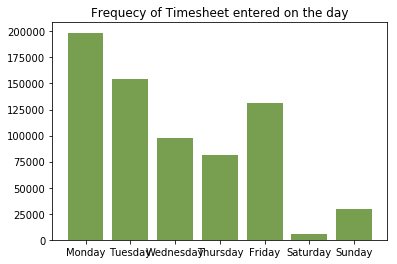

In [44]:
import matplotlib.pyplot as pl
import numpy as np

pl.bar(datatime['theDayNum'],datatime['count'],align='center',alpha=0.5)
pl.xticks(datatime['theDayNum'],datatime['theDayName'])
pl.title('Frequecy of Timesheet entered on the day')
pl.show()
